In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("Plots")
Pkg.add("ForwardDiff")
Pkg.add("SymPy")
using LinearAlgebra, Plots
import ForwardDiff as FD
# import MeshCat as mc 
# using JLD2
using Test
using SymPy
# using Random
# include(joinpath(@__DIR__,"utils/cartpole_animation.jl"))
# include(joinpath(@__DIR__,"utils/basin_of_attraction.jl"))

  Activating environment at `~/danaus_ros_ws/julia_eth/Project.toml`
    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed Expat_jll ─────────── v2.6.2+0
   Installed Xorg_libSM_jll ────── v1.2.4+0
   Installed LAME_jll ──────────── v3.100.2+0
   Installed Xorg_libXext_jll ──── v1.3.6+0
   Installed FixedPointNumbers ─── v0.8.5
   Installed SpecialFunctions ──── v2.4.0
   Installed HTTP ──────────────── v1.10.8
   Installed Glib_jll ──────────── v2.80.2+0
   Installed Libgpg_error_jll ──── v1.49.0+0
   Installed FriBidi_jll ───────── v1.0.14+0
   Installed Cairo_jll ─────────── v1.18.0+2
   Installed Unitful ───────────── v1.19.1
   Installed Colors ────────────── v0.12.11
   Installed LZO_jll ───────────── v2.10.2+0
   Installed Libuuid_jll ───────── v2.40.1+0
   Installed Xorg_libXrender_jll ─ v0.9.11+0
   Installed Fontconfig_jll ────── v2.13.96+0
   Installed JpegTurbo_jll ─────── v3.0.3+0
   Installed Xorg_libICE_jll ───── v1.1.1+0
  

In [2]:
function rk4(params::NamedTuple, x::Vector, u::Vector, dt::Float64)
    k1 = dt*dynamics(params, x, u)
    k2 = dt*dynamics(params, x + 0.5*k1, u)
    k3 = dt*dynamics(params, x + 0.5*k2, u)
    k4 = dt*dynamics(params, x + k3, u)
    
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [3]:
# function thetadot2omega(thetadot, angles)
#     phi = angles(1);
#     theta = angles(2);
#     psi = angles(3);
#     W = [
#         1, 0, -sin(theta)
#         0, cos(phi), cos(theta)*sin(phi)
#         0, -sin(phi), cos(theta)*cos(phi)
#     ];
#     omega = W * thetadot;
#     return omega;
# end

# function omega2thetadot(omega, angles)
#     phi = angles(1);
#     theta = angles(2);
#     psi = angles(3);
#     W = [
#         1, 0, -sin(theta)
#         0, cos(phi), cos(theta)*sin(phi)
#         0, -sin(phi), cos(theta)*cos(phi)
#     ];
#     thetadot = inv(W) * omega;
#     return thetadot;
# end


function dynamics(params::NamedTuple, X::Vector, u::Vector)
    g = params.g
    L = params.L
    J = params.J
    
    γ, β, α, ϕ, θ, ϕ_dot, θ_dot, x, y, z, x_dot, y_dot, z_dot = X
    a, wx, wy, wz = u

    Rx = [1 0 0; 0 cos(γ) -sin(γ); 0 sin(γ) cos(γ)]
    Ry = [cos(β) 0 sin(β); 0 1 0; -sin(β) 0 cos(β)]
    Rz = [cos(α) -sin(α) 0; sin(α) cos(α) 0; 0 0 1]
    R = Rz*Ry*Rx

    k_x = cos(α)*sin(β)*cos(γ) + sin(α)*sin(γ)
    k_y = sin(α)*sin(β)*cos(γ) - cos(α)*sin(γ)
    k_z = cos(β)*cos(γ)
    
    pos_ddot = R * [0; 0; a] + [0; 0; -g]
    x_ddot, y_ddot, z_ddot = pos_ddot

    rot_dot = [cos(β)*cos(γ) -sin(γ) 0; cos(β)*sin(γ) cos(γ) 0; -sin(β) 0 1]\[wx; wy; wz]
    γ_dot, β_dot, α_dot = rot_dot
    
    ϕ_ddot = (3/(2*L*cos(θ)) * (k_y*cos(ϕ) + k_z*sin(ϕ))) * (a) + 2*θ_dot*ϕ_dot*tan(θ)
    θ_ddot = (3/(2*L) * (-k_x*cos(θ) - k_y*sin(ϕ)*sin(θ) + k_z*cos(ϕ)*sin(θ))) * (a) - ϕ_dot^2*sin(θ)*cos(θ)
    
    return [γ_dot; β_dot; α_dot; ϕ_dot; θ_dot; ϕ_ddot; θ_ddot; x_dot; y_dot; z_dot; x_ddot; y_ddot; z_ddot]
end


dynamics (generic function with 1 method)

13×13 Matrix{Float64}:
  1.0           0.0          0.0  …  0.0        0.0        0.0
  0.0           1.0          0.0     0.0        0.0        0.0
  0.0           0.0          1.0     0.0        0.0        0.0
 -0.000836519   0.0          0.0     0.0        0.0        0.0
  0.0          -0.000836519  0.0     0.0        0.0        0.0
 -0.150594      0.0          0.0  …  0.0        0.0        0.0
  0.0          -0.150594     0.0     0.0        0.0        0.0
  0.0           0.000605556  0.0     0.0111111  0.0        0.0
 -0.000605556   0.0          0.0     0.0        0.0111111  0.0
  0.0           0.0          0.0     0.0        0.0        0.0111111
  0.0           0.109        0.0  …  1.0        0.0        0.0
 -0.109         0.0          0.0     0.0        1.0        0.0
  0.0           0.0          0.0     0.0        0.0        1.0

13×4 Matrix{Float64}:
 0.0          0.0111111     0.0          0.0
 0.0          0.0           0.0111111    0.0
 0.0          0.0           0.0          0.0111111
 0.0         -3.09779e-6    0.0          0.0
 0.0          0.0          -3.09779e-6   0.0
 0.0         -0.000836519   0.0          0.0
 0.0          0.0          -0.000836519  0.0
 0.0          0.0           2.2428e-6    0.0
 0.0         -2.2428e-6     0.0          0.0
 6.17284e-5   0.0           0.0          0.0
 0.0          0.0           0.000605556  0.0
 0.0         -0.000605556   0.0          0.0
 0.0111111    0.0           0.0          0.0

=====================================Final Iteration: 999
Kinf: [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.9904236667986895 0.0 0.0 1.7209841293144688; 12.557959634287336 0.0 0.0 -26.624388839243494 0.0 -7.288127113059946 0.0 0.0 0.9302392965362474 0.0 0.0 1.8796437942834028 0.0; 0.0 12.557959634287336 0.0 0.0 -26.624388839243494 0.0 -7.288127113059946 -0.9302392965362474 0.0 0.0 -1.8796437942834028 0.0 0.0; 0.0 0.0 0.9944598759822899 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0]


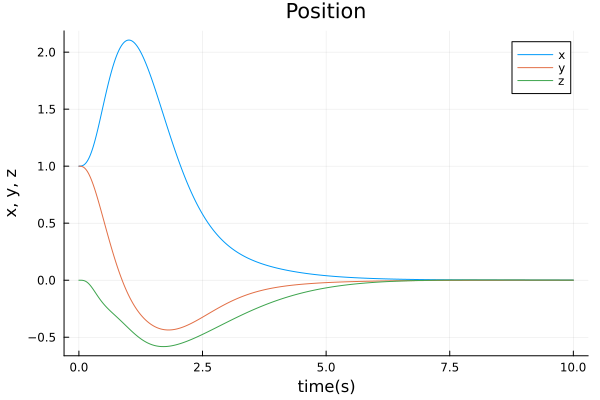

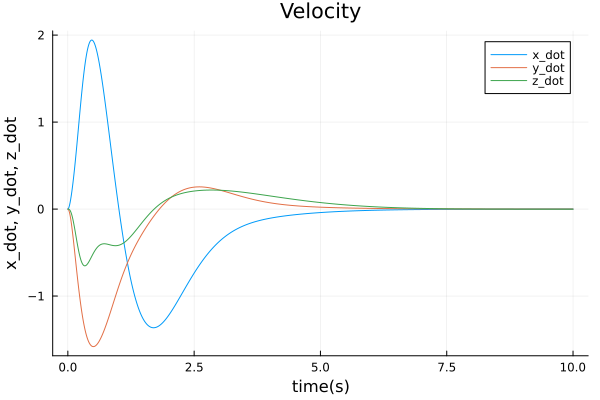

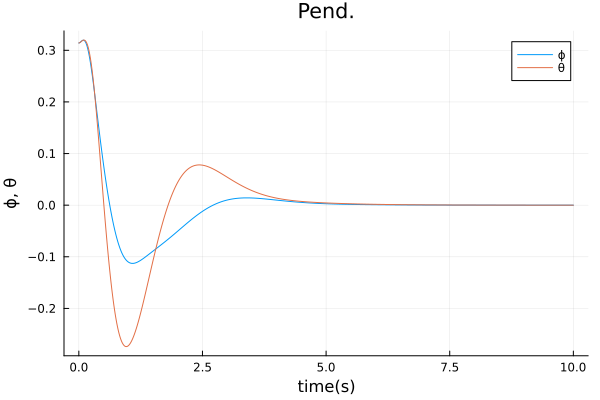

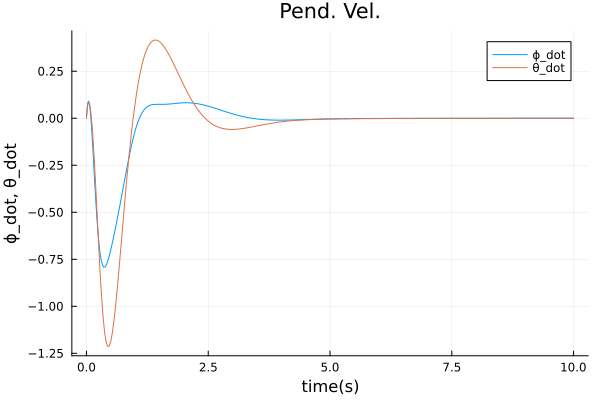

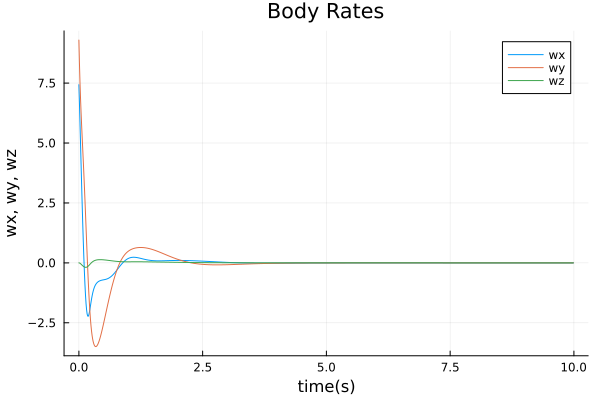

In [8]:
nx = 13
nu = 4

g = 9.81
L = 1.086

          # <ixx>0.00327227</ixx>
          # <ixy>0.00000791</ixy>
          # <ixz>0.00009286</ixz>
          # <iyy>0.00319928</iyy>
          # <iyz>0.00005426</iyz>
          # <izz>0.00529553</izz>
# J = 1.0*diagm([0.4 * J_M * J_R^2 + 2 * J_l ^ 2 * J_m; 0.4 * J_M * J_R^2 + 2 * J_l ^ 2 * J_m; 0.4 * J_M * J_R^2 + 4 * J_l ^ 2 * J_m])
# println("___________ J __________________")
# display(J)
J = 1.0*diagm([0.00327227; 0.00319928; 0.00529553])

# x0 =    [0.5; 0.5; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
# xgoal = [0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
# ugoal = [0; 0; 0; g]

x0 =    [0; 0; 0; pi/10; pi/10; 0; 0; 1; 1; 0; 0; 0; 0]
xgoal = [0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0; 0]
ugoal = [g; 0; 0; 0]

params = (g = 9.81, L = 1.086, J=J)

dt = 1/90

A = FD.jacobian(x -> rk4(params, x, ugoal, dt), xgoal)
B = FD.jacobian(u -> rk4(params, xgoal, u, dt), ugoal)

display("text/plain", A)
print("=====================================")
display("text/plain", B)
print("=====================================")

# display("text/plain", B)

# x,y,z altogether
Q = 1.0*diagm([1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1; 1])
R = 1.0*diagm([1; 1; 1; 1])

# Q = 1.0*diagm([0; 0; 0; 1; 1; 0; 0.5; 0.5; 0; 0; 0; 0; 0])

# Q = 1.0*diagm([1; 1; 1; 0.5; 0.5; 0.5; 0; 0; 0; 0; 0; 0])
# Q = 1.0*diagm([1; 1; 1; 0; 0; 0])
# R = 1.0*diagm([1000; 1000; 1000; 10])

# sing = 1e-6

P = deepcopy(Q)
# display(B'*P*B)
K_old = (R + B'*P*B)\B'*P*A
P_old = Q + A'*P*(A-B*K_old)

Kinf = deepcopy(K_old)

for i = 1:10000
    # println("Iteration: ", i)
    K_new = (R + B'*P_old*B)\B'*P_old*A
    P_new = Q + A'*P_old*(A-B*K_new)
    if norm(K_new - K_old) < 1e-9
        Kinf = K_new
        println("Final Iteration: ", i)
        println("Kinf: ", Kinf)
        break
    end
    K_old = K_new
    P_old = P_new
end

tf = 10.0
t_vec = 0:dt:tf
N = length(t_vec)
X = [zeros(nx) for i = 1:N]
U = [zeros(nu) for i = 1:N-1]
X[1] = x0

for k = 1:N-1
    u = ugoal - Kinf*(X[k] - xgoal)
    X[k+1] = rk4(params, X[k], u, dt)
    U[k] = u
    # print(k)
      # X[k+1] = A_d * X[k] + B_d *(ugoal - Kinf*(X[k] - xgoal))
      # X[k+1] = A_rk * X[k] + B_rk *(ugoal - Kinf*(X[k] - xgoal))
end

Xm = hcat(X...)
Um = hcat(U...)

# 1 2  3  4  5   6      7     8  9  10  11     12     13
# γ, β, α, ϕ, θ, ϕ_dot, θ_dot, x, y, z, x_dot, y_dot, z_dot

display(plot(t_vec,(Xm[8:10,:])',title = "Position",
            xlabel = "time(s)", ylabel = "x, y, z",
            label = ["x" "y" "z"]))

display(plot(t_vec,(Xm[11:13,:])',title = "Velocity",
            xlabel = "time(s)", ylabel = "x_dot, y_dot, z_dot",
            label = ["x_dot" "y_dot" "z_dot"]))

display(plot(t_vec,(Xm[4:5,:])',title = "Pend.",
            xlabel = "time(s)", ylabel = "ϕ, θ",
            label = ["ϕ" "θ"]))

display(plot(t_vec,(Xm[6:7,:])',title = "Pend. Vel.",
            xlabel = "time(s)", ylabel = "ϕ_dot, θ_dot",
            label = ["ϕ_dot" "θ_dot"]))

display(plot(t_vec[1:end-1], (Um[2:4,:])', title = "Body Rates",
            xlabel = "time(s)", ylabel="wx, wy, wz",
            label = ["wx" "wy" "wz"]))

# display(plot(t_vec[1:end-1], (Um[1,:]/9.81)', title = "Thrust",
#             xlabel = "time(s)", ylabel="a",
#             label = ["a"]))



In [6]:
function print_as_numpy(julia_matrix::Matrix)
    rows = size(julia_matrix)[1]
    cols = size(julia_matrix)[2]
    
    println("[")
    
    for i in 1:rows
        print("[")
        for j in 1:cols
            print(julia_matrix[i, j])
            if j < cols
                print(", ")
            end
        end
        println("]")
        if i < rows
            println(",")
        end
    end
    
    println("]")

end

print_as_numpy (generic function with 1 method)

In [7]:
print_as_numpy(A)

print_as_numpy(B)

[
[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[-0.0013167139499560476, 0.0, 0.0, 1.0013167139499561, 0.0, 0.011115986759706566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[0.0, -0.0013167139499560476, 0.0, 0.0, 1.0013167139499561, 0.0, 0.011115986759706566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[-0.2370605002450466, 0.0, 0.0, 0.2370605002450466, 0.0, 1.0013167139499561, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[0.0, -0.2370605002450466, 0.0, 0.0, 0.2370605002450466, 0.0, 1.0013167139499561, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
,
[0.0, 0.0006055555555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.01111111111111111, 0.0, 0.0]
,
[-0.0006055555555555556, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.01111111111111111, 0.0]
,
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.01111111111111111]
,
[0.0, 0.10900000000000001, 0.0, 0.0, 0.